# Homework 6: Fast fourier transform 
Name: Amro Imam

## 1. LIGO

Use Fourier techniques to find the merging black hole signal *GW150914*. Write a Python program to read in the LIGO data, do some simple cleaning, and find the signal.

LIGO has two independent observatories, one in Livingston, LO and
the other in Hanford, WA. Both detectors must see a signal within
10ms of each other for it to count! A window of data (32 seconds)
around the time of the event is available for download here: 

Hanford data:
https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5

Livingston data:
https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5

These are HDF5 files. These files are much smaller and quicker to read/write than plain text files. The **h5py** library (included in Anaconda and available through pip) interacts with these files. See the documentation: https://docs.h5py.org/en/stable/

A function to do so is:

In [ ]:
import h5py
import numpy as np

In [ ]:
def loadLIGOdata(filename):
    f = h5py.File(filename, "r")
    strain = f['strain/Strain'][...]
    t0 = f['strain/Strain'].attrs['Xstart'] 
    dt = f['strain/Strain'].attrs['Xspacing'] 
    t = t0 + dt * np.arange(strain.shape[0]) 
    f.close()
    return t, strain

In [ ]:
Hanford = list(loadLIGOdata('Hanford.hdf5'))
Livingston = list(loadLIGOdata('Livingston.hdf5'))


This returns the time (in seconds) and the strain (which has no units). The measurements in this data set are evenly sampled at 4096Hz.

The strain $h(t)$ is what is measured by LIGO. You can think of it as the fractional change in the length of the 4km interferometer arms:
$\Delta L/L$. Plot the strain as a function of time for both detectors. Gravitational waves from astrophysical sources produce a maximum strain on Earth of about $10^{−21}$. Can you see a gravitational wave in the data?

In [ ]:
Hanford = list(loadLIGOdata('Hanford.hdf5'))
Hanford[0] = Hanford[0] - Hanford[0][0]              #Subtracting initial t value to start at t=0.
Livingston = list(loadLIGOdata('Livingston.hdf5'))
Livingston[0] = Livingston[0] - Livingston[0][0]

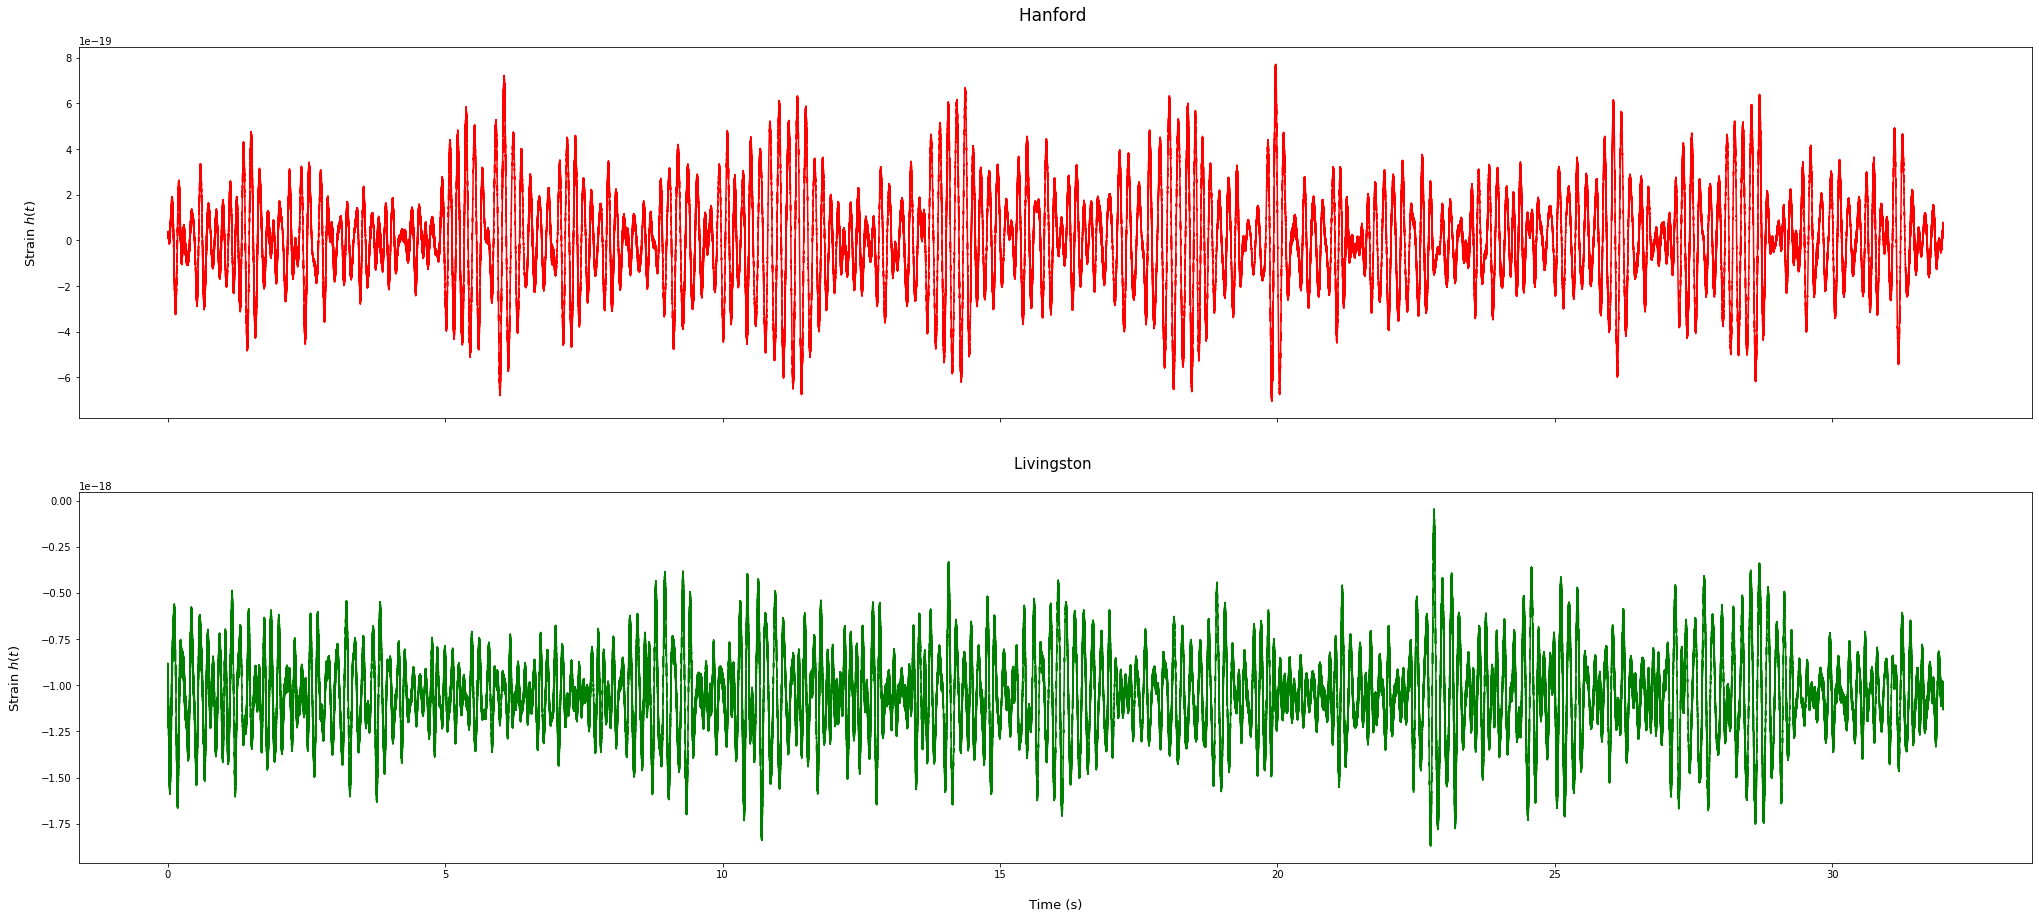

In [ ]:
#Plotting The Data

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,figsize=(35,15),sharex=True)

axs[0].plot(Hanford[0],Hanford[1],'r')
axs[0].set_title('Hanford \n',fontsize=17)
axs[0].set(ylabel='Strain $h(t)$\n')
axs[0].yaxis.label.set_fontsize(13)

axs[1].plot(Livingston[0],Livingston[1],'g')
axs[1].set_title('Livingston \n',fontsize=15)
axs[1].set(xlabel='\nTime (s)',ylabel='Strain $h(t)$\n')
axs[1].xaxis.label.set_fontsize(13)
axs[1].yaxis.label.set_fontsize(13)
plt.show()

You probably didn't see much. Most of the strain is “noise” coming from various physical effects in the detector. To find how the noise affects the data, plot the power spectral density $P = |h(f)|^2$ of the data for each detector using FFT. 

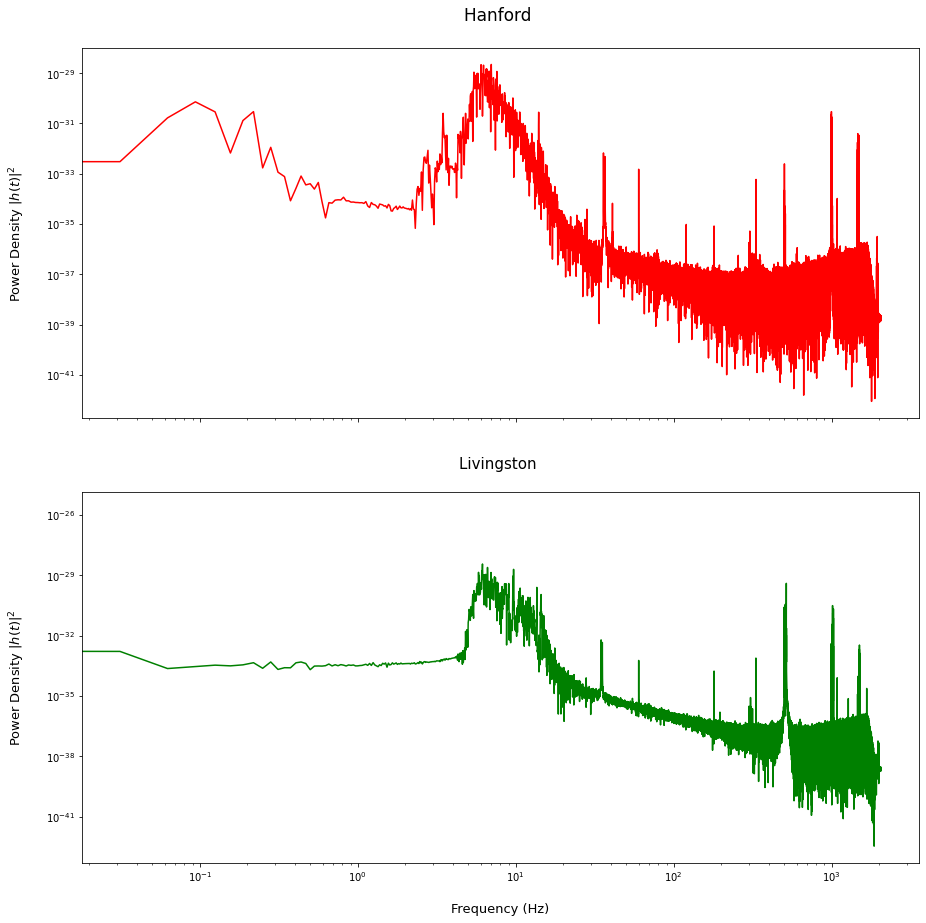

In [ ]:
import scipy.fft
fft_H = scipy.fft.rfft(Hanford[1])                              # Performing the fft
pow_H = [abs(i)**2 for i in fft_H]                              # Taking Square of the norm for power density plot.
freq_H = scipy.fft.rfftfreq(len(Hanford[1]), d=1./4096)         # Converting time series to frequency

fft_L = scipy.fft.rfft(Livingston[1])
pow_L = [abs(i)**2 for i in fft_L]
freq_L = scipy.fft.rfftfreq(len(Livingston[1]), d=1./4096)


fig, axs = plt.subplots(2,figsize=(15,15),sharex=True)

# plt.loglog()
axs[0].plot(freq_H,pow_H,'r')
axs[0].set_title('Hanford \n',fontsize=17)
axs[0].set(ylabel='Power Density $|h(t)|^2$\n')
axs[0].yaxis.label.set_fontsize(13)
axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(freq_L,pow_L,'g')
axs[1].set_title('Livingston \n',fontsize=15)
axs[1].set(xlabel='\nFrequency (Hz)',ylabel='Power Density $|h(t)|^2$\n')
axs[1].xaxis.label.set_fontsize(13)
axs[1].yaxis.label.set_fontsize(13)
axs[1].set_yscale('log')
axs[1].set_xscale('log')

plt.show()

The power spectral density shows a lot of power for $f < 30Hz$ and many spectral lines. These lines correspond to resonances in the LIGO machinery (the cables suspending the mirrors, the 60Hz electrical frequency, etc). These are clearly noise! Filtering out particular modes in Fourier space is not difficult, simply multiply the DFT of your data $h(f)$ by a transfer function $H(f)$, then perform the inverse transform to see the filtered data. Here are two very simple filters:
\begin{equation}
H_{step}(f)=\frac{1}{1+(f/f_0)^{2n}},
\end{equation}
and 
\begin{equation}
H_{gauss}(f)=1-\exp{\left[-\frac{(f-f_0)^2}{2 \sigma^2}\right]}.
\end{equation}
In the above, $f_0$ is the location of the filter and $n$ or $\sigma$ control the width. What does each filter do?

$H_{step}(f) $ removes unwanted frequencies in the spectrum before a particular set value $f_0$. 

$H_{gauss}(f)$  tapers off peaks, preventing them from having an excessively (and unjustified) spectral power density. It's centered at $f_0$, and the value $\sigma$ chosen determines how much of the peak is tapered off.    

LIGO is most sensitive between 35Hz and 350Hz. Use $H_{step}$ with $n \sim 8$ to filter out the modes outside this band. Plot the resulting waveform and the power spectral density

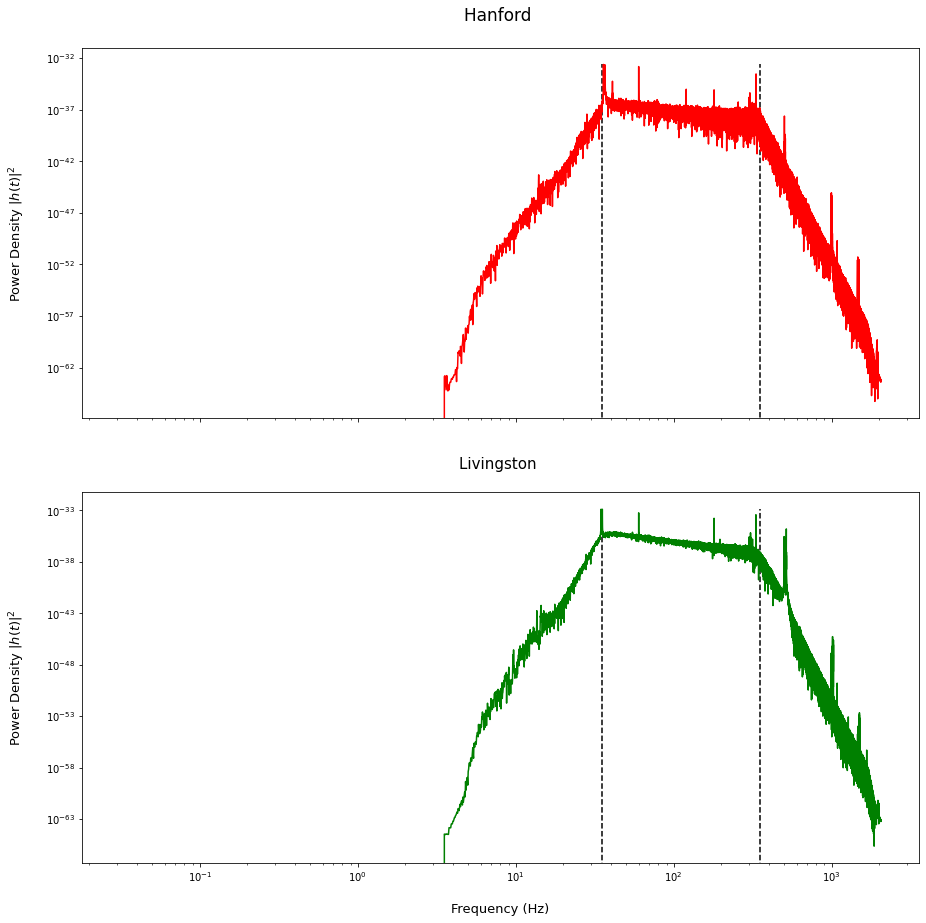

In [ ]:
H_35_Hanford = [1-1/(1+(i/35.0)**(2*8)) for i in freq_H]      #Creating filter for 35 Hz. Used 1-expression to remove everything before 35 Hz.
H_350_Hanford = [1/(1+(i/350.0)**(2*8)) for i in freq_H]
H_Step_All = [i*j*l for i,j,l in zip(H_35_Hanford,H_350_Hanford,fft_H)]      #Multiplying H(f) of the 35Hz and 350Hz filters by h(f)
pow_H_All = [abs(i)**2 for i in H_Step_All]                                # Taking Square of the norm for power density plot.

H_35_Livingston = [1-1/(1+(i/35.0)**(2*8)) for i in freq_L]
H_350_Livingston = [1/(1+(i/350.0)**(2*8)) for i in freq_L]
L_Step_All = [i*j*l for i,j,l in zip(H_35_Livingston,H_350_Livingston,fft_L)]
pow_L_All = [abs(i)**2 for i in L_Step_All]

fig, axs = plt.subplots(2,figsize=(15,15),sharex=True)

# plt.loglog()
axs[0].plot(freq_H,pow_H_All,'r')
axs[0].set_title('Hanford \n',fontsize=17)
axs[0].set(ylabel='Power Density $|h(t)|^2$\n')
axs[0].yaxis.label.set_fontsize(13)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].vlines(x=35.0,ymin=min(pow_H_All),ymax=max(pow_H_All),linestyle='--')     #Vertical Lines Identifying the 35 and 350 Hz Mark.
axs[0].vlines(x=350.0,ymin=min(pow_H_All),ymax=max(pow_H_All),linestyle='--')

# plt.loglog()
axs[1].plot(freq_L,pow_L_All,'g')
axs[1].set_title('Livingston \n',fontsize=15)
axs[1].set(xlabel='\nFrequency (Hz)',ylabel='Power Density $|h(t)|^2$\n')
axs[1].xaxis.label.set_fontsize(13)
axs[1].yaxis.label.set_fontsize(13)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].vlines(x=35.0,ymin=min(pow_L_All),ymax=max(pow_L_All),linestyle='--')
axs[1].vlines(x=350.0,ymin=min(pow_L_All),ymax=max(pow_L_All),linestyle='--')

plt.show()

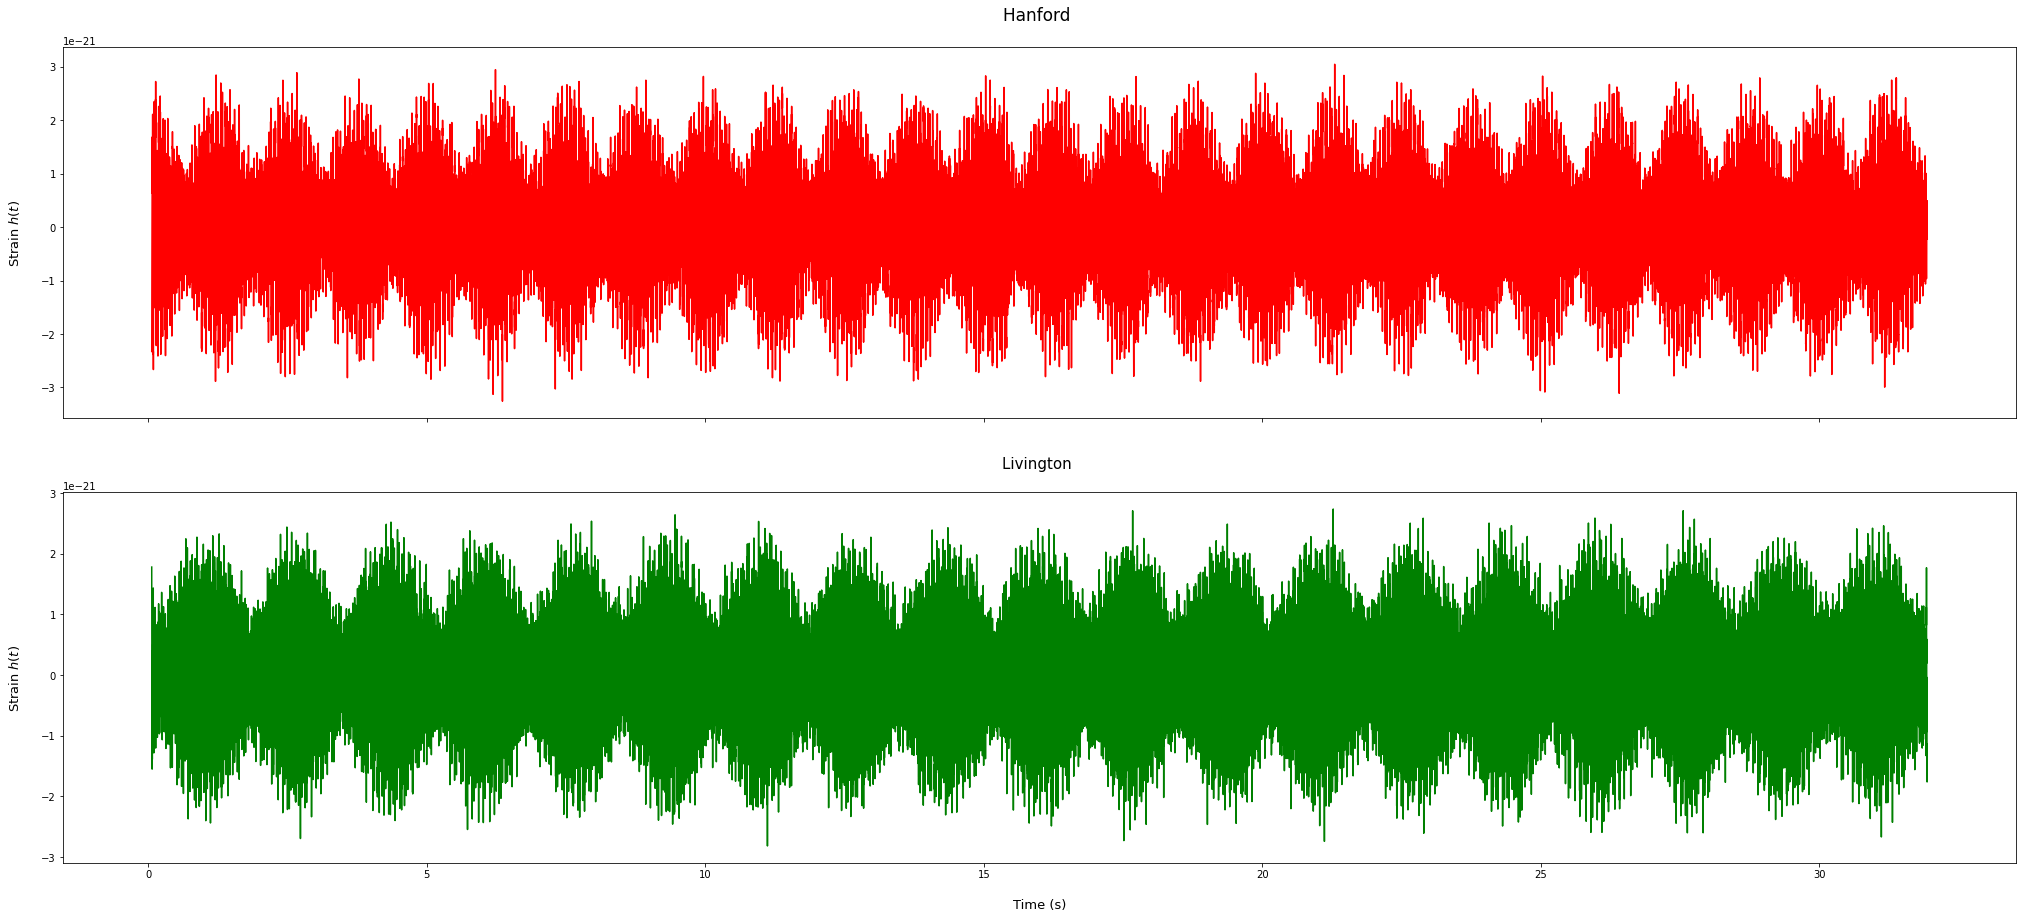

In [ ]:
Inv_H = scipy.fft.irfft(H_Step_All)
Inv_L = scipy.fft.irfft(L_Step_All)

fig, axs = plt.subplots(2,figsize=(35,15),sharex=True)

axs[0].plot(Hanford[0][250:-250],Inv_H[250:-250],'r')
axs[0].set_title('Hanford \n',fontsize=17)
axs[0].set(ylabel='Strain $h(t)$\n')
axs[0].yaxis.label.set_fontsize(13)
# axs[0].set_yscale('log')
# axs[0].set_xscale('log')


axs[1].plot(Livingston[0][250:-250],Inv_L[250:-250],'g')
axs[1].set_title('Livington \n',fontsize=15)
axs[1].set(xlabel='\nTime (s)',ylabel='Strain $h(t)$\n')
axs[1].xaxis.label.set_fontsize(13)
axs[1].yaxis.label.set_fontsize(13)
# axs[1].set_yscale('log')
# axs[1].set_xscale('log')

plt.show()

See a signal yet? Use the $H_{gauss}$ filter to remove spectral lines from the data as well. Plot the resulting waveform and power spectrum.

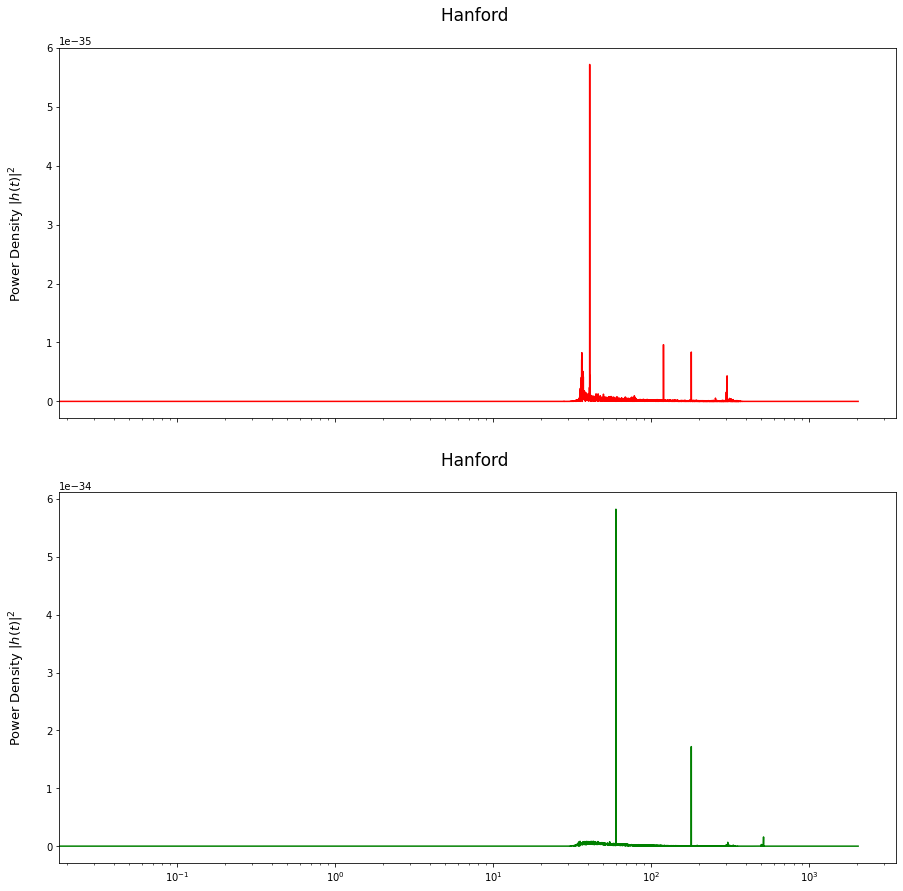

In [ ]:
mini = 10**(-17)

peaks_H = [i for i in H_Step_All if i.real > mini]

H_Gauss = []
for i in peaks_H:    #Creates Gauss Filter for Peaks
  H_f0 = []
  count = H_Step_All.index(i)
  f0 = freq_H[count]
  for f in freq_H:
    t = 1-np.exp((-((f-f0)**2))/(2*(0.1**2)) )
    H_f0.append(t)
  H_Gauss.append(H_f0)

H_Gauss_Final = []
for i in range(len(H_Step_All)):  #multiplying everything together
  t=1
  for p in H_Gauss:
    t = t*p[i]
  t = t*H_Step_All[i]
  H_Gauss_Final.append(t)

#Livingston

peaks_L = [i for i in L_Step_All if i.real > mini]

L_Gauss = []
for i in peaks_L:    #Creates Gauss Filter for Peaks
  L_f0 = []
  count = L_Step_All.index(i)
  f0 = freq_L[count]
  for f in freq_L:
    t = 1-np.exp((-((f-f0)**2))/(2*(0.1**2)) )
    L_f0.append(t)
  L_Gauss.append(L_f0)

L_Gauss_Final = []
for i in range(len(L_Step_All)):  #multiplying everything together
  t=1
  for p in L_Gauss:
    t = t*p[i]
  t = t*L_Step_All[i]
  L_Gauss_Final.append(t)

H_Gauss_Final_Pow = [abs(i)**2 for i in H_Gauss_Final]
L_Gauss_Final_Pow = [abs(i)**2 for i in L_Gauss_Final]

fig, axs = plt.subplots(2,figsize=(15,15),sharex=True)

# plt.loglog()
axs[0].plot(freq_H,H_Gauss_Final_Pow,'r')
axs[0].set_title('Hanford \n',fontsize=17)
axs[0].set(ylabel='Power Density $|h(t)|^2$\n')
axs[0].yaxis.label.set_fontsize(13)
# axs[0].set_yscale('log')
axs[0].set_xscale('log')


# plt.loglog()
axs[1].plot(freq_L,L_Gauss_Final_Pow,'g')
axs[1].set_title('Hanford \n',fontsize=17)
axs[1].set(ylabel='Power Density $|h(t)|^2$\n')
axs[1].yaxis.label.set_fontsize(13)
# axs[0].set_yscale('log')
axs[1].set_xscale('log')


In [ ]:
peaks_L

[(3.3869737452567e-17-1.2958857996283414e-17j),
 (3.321923477652754e-17-1.4371259428706234e-17j),
 (1.2618453993830196e-17+1.6846068715919256e-18j)]

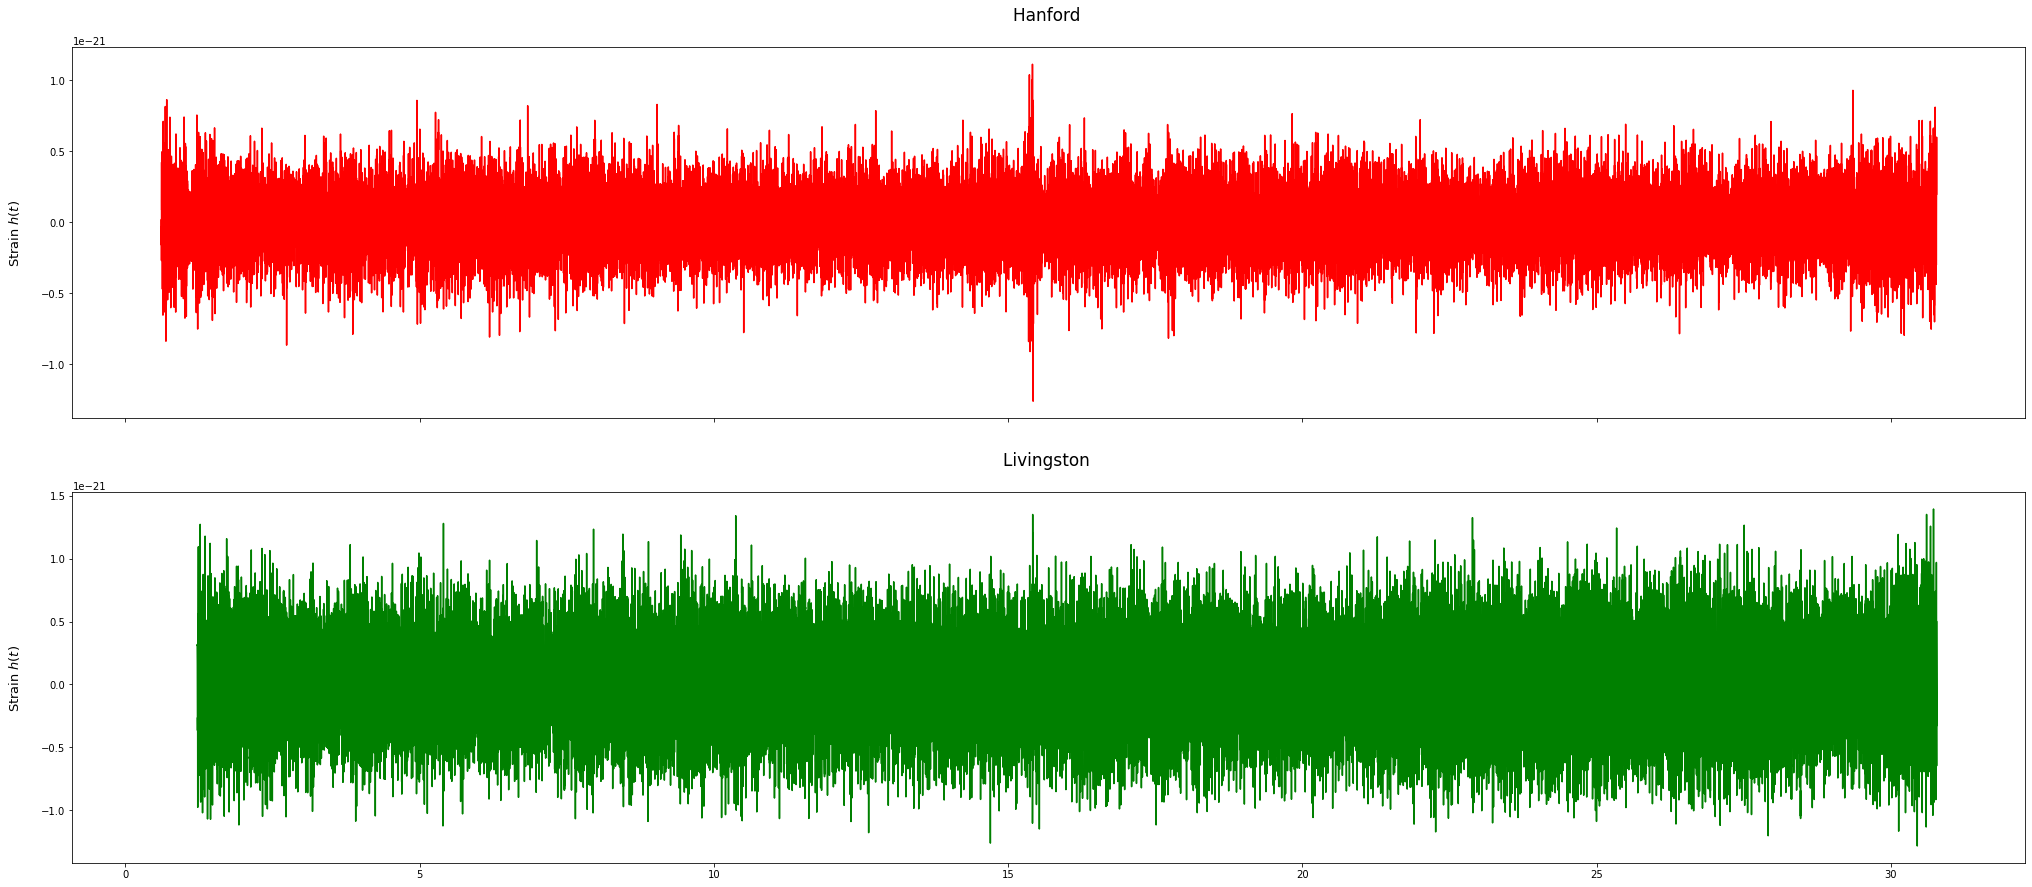

In [ ]:
Inv_Gauss_Final_H = scipy.fft.irfft(H_Gauss_Final)
Inv_Gauss_Final_L = scipy.fft.irfft(L_Gauss_Final)
fig, axs = plt.subplots(2,figsize=(35,15),sharex=True)

# plt.loglog()
axs[0].plot(Hanford[0][2500:-5000],Inv_Gauss_Final_H[2500:-5000],'r')
axs[0].set_title('Hanford \n',fontsize=17)
axs[0].set(ylabel='Strain $h(t)$\n')
axs[0].yaxis.label.set_fontsize(13)

axs[1].plot(Livingston[0][5000:-5000],Inv_Gauss_Final_L[5000:-5000],'g')
axs[1].set_title('Livingston \n',fontsize=17)
axs[1].set(ylabel='Strain $h(t)$\n')
axs[1].yaxis.label.set_fontsize(13)


This dataset contains the first ever detection of a binary black hole merger! What time does it occur at? Remember: a real signal appears in both data sets with a time delay of no more than 10ms. Compute the cross-correlation beweteen the signal at Handford and Livingston.


GW detection Occured @t=16s.

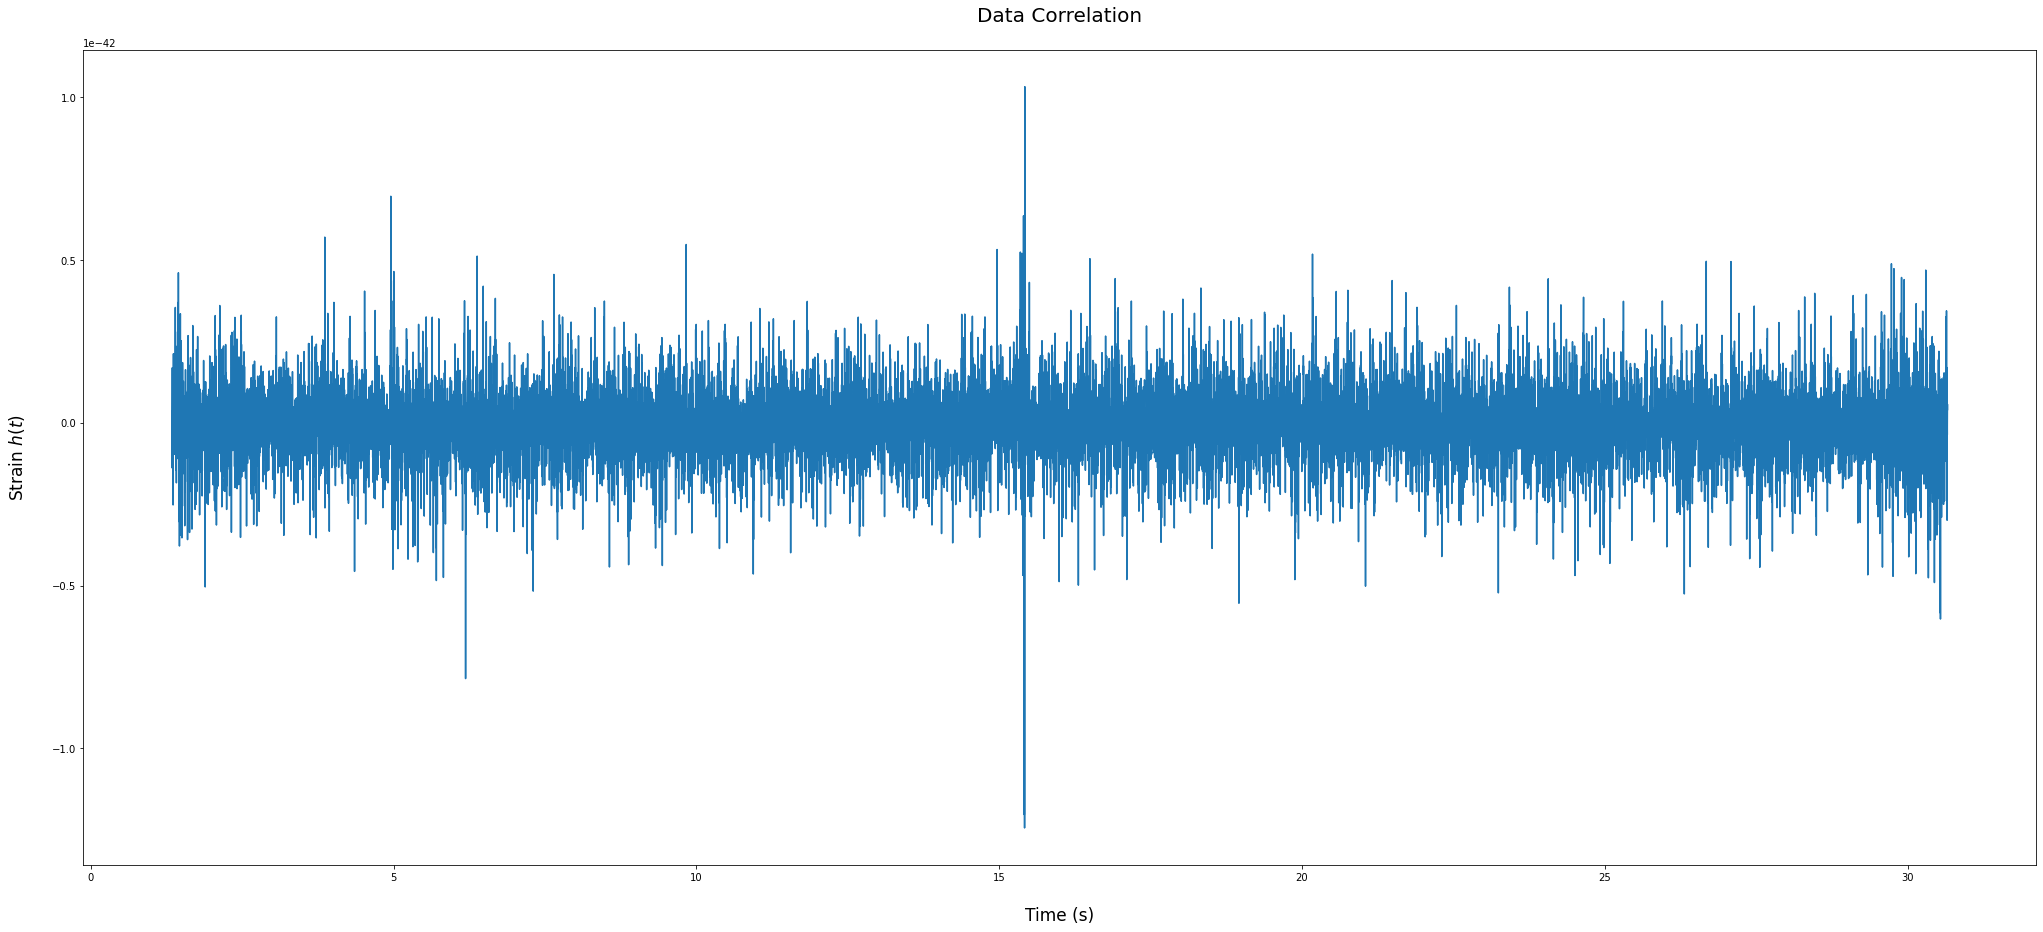

In [ ]:
cor = [i*j for i,j in zip(Inv_Gauss_Final_H[5500:-5500],Inv_Gauss_Final_L[5500:-5500])]

plt.figure(figsize=(35,15))
plt.plot(Livingston[0][5500:-5500],cor)
plt.ylabel('Strain $h(t)$\n',fontsize=17)
plt.xlabel('\nTime (s)',fontsize=17)
plt.title('Data Correlation\n',fontsize=20)
# plt.margins(x=0.00001)
plt.show()